## AMAT 250: Problem Set 2

### Item 1B
You and several friends are about to prepare a lasagna dinner. <br>The tasks to be performed, their immediate predecessors, and their estimated durations are as follows

<img src="img2.png" width=450 height=450/>

1. Construct the project network for preparing this dinner.
2. Find the earliest start time and earliest completion time for each activity.
3. Find the latest start time and latest completion time for each activity.
4. Find the slack for each activity. Which of the paths is a critical path?
5. Because of a phone call, you were interrupted for 6 minutes when you should have been cutting the onions and mushrooms. <br>By how much will the dinner be delayed?
6. If you use your food processor, which reduces the cutting time from 7 to 2 minutes, will the dinner still be delayed?

(Answers for II, III, and IV must be tabulated.)

____________________________

### Some notes for this simulation

The table above is transformed into a `.csv` file as the input file for the simulation
In addition, each column in the DataFrame used below are as follows:
- `task` - task label
- `precedence` - the immediate predecessor of the task, i.e., this task/s should be completed first
- `duration` - time needed for the task to be completed
- `ES` (Early Start time) - earliest start time for the task given
- `EF` (Early Finish time) - earliest finish time for the task given
- `LS` (Late Start time) - latest start time for the task given
- `LF` (Late Finish time) - latest finish time for the task given
- `slack` - slack time for each task/activity
- `Is critical?` - the tasks that are critical, i.e., cannot be delayed

___________

### Creating the project network

In [1]:
# !pip install networkx

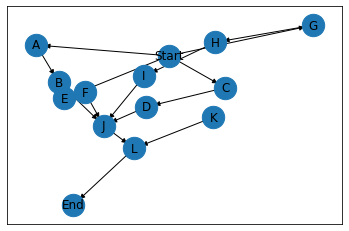

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()
g.add_nodes_from(["Start", "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "End"])
g.add_edge("Start","A")
g.add_edge("Start","C")
g.add_edge("Start","E")
g.add_edge("Start","G")
g.add_edge("A","B")
g.add_edge("C","D")
g.add_edge("E","F")
g.add_edge("G","H")
g.add_edge("H","I")
g.add_edge("B","J")
g.add_edge("D","J")
g.add_edge("F","J")
g.add_edge("I","J")
g.add_edge("J","L")
g.add_edge("K","L")
g.add_edge("L","End")

# Specify the edges you want here
red_edges = []
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in g.edges()]
black_edges = [edge for edge in g.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(g, pos, edgelist=black_edges, arrows=True)
plt.show()

### Main code for calculations

In [3]:
# import libraries
import numpy as np
import pandas as pd

In [4]:
# forces warning to not be displayed
import warnings
warnings.filterwarnings("ignore")

In [5]:
# import dataset in csv format
data = pd.read_csv("data.csv")
data

,task,precedence,duration
0,A,NaN,30
1,B,A,5
2,C,NaN,2
3,D,C,3
4,E,NaN,7
5,F,E,25
6,G,NaN,15
7,H,G,10
8,I,H,2
9,J,I F D B,10


In [6]:
# adding additional columns
data["precedence"] = data["precedence"].fillna(-1) # starting nodes
data["ES"] = np.nan
data["EF"] = np.nan
data["LS"] = np.nan
data["LF"] = np.nan
data["slack"] = np.nan
data["Is critical?"] = np.nan

data

,task,precedence,duration,ES,EF,LS,LF,slack,Is critical?
0,A,-1,30,NaN,NaN,NaN,NaN,NaN,NaN
1,B,A,5,NaN,NaN,NaN,NaN,NaN,NaN
2,C,-1,2,NaN,NaN,NaN,NaN,NaN,NaN
3,D,C,3,NaN,NaN,NaN,NaN,NaN,NaN
4,E,-1,7,NaN,NaN,NaN,NaN,NaN,NaN
5,F,E,25,NaN,NaN,NaN,NaN,NaN,NaN
6,G,-1,15,NaN,NaN,NaN,NaN,NaN,NaN
7,H,G,10,NaN,NaN,NaN,NaN,NaN,NaN
8,I,H,2,NaN,NaN,NaN,NaN,NaN,NaN
9,J,I F D B,10,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# transforming multiple precedence of a node to a Python list
for i in range(len(data)):
    if data["precedence"][i] != -1 and len(data["precedence"][i]) != 1:
        data["precedence"][i] = list(data["precedence"][i].split(" "))
data

,task,precedence,duration,ES,EF,LS,LF,slack,Is critical?
0,A,-1,30,NaN,NaN,NaN,NaN,NaN,NaN
1,B,A,5,NaN,NaN,NaN,NaN,NaN,NaN
2,C,-1,2,NaN,NaN,NaN,NaN,NaN,NaN
3,D,C,3,NaN,NaN,NaN,NaN,NaN,NaN
4,E,-1,7,NaN,NaN,NaN,NaN,NaN,NaN
5,F,E,25,NaN,NaN,NaN,NaN,NaN,NaN
6,G,-1,15,NaN,NaN,NaN,NaN,NaN,NaN
7,H,G,10,NaN,NaN,NaN,NaN,NaN,NaN
8,I,H,2,NaN,NaN,NaN,NaN,NaN,NaN
9,J,"[I, F, D, B]",10,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# forward pass
# calculating ES and EF
for i in range(len(data)):
    predecessors = data["precedence"][i]
    if data['precedence'][i] == -1:   # for nodes without predecessors
        data["ES"][i] = 0
        data["EF"][i] = data["duration"][i] + data["ES"][i]
    elif (data["precedence"][i] != -1) and (len(data["precedence"][i]) == 1):  # for nodes with one predecessor
        for j in range(len(data)):
            if data["task"][j] == data["precedence"][i]:
                data["ES"][i] = data["EF"][j]
                data["EF"][i] = data["EF"][j] + data["duration"][i]
    else: # for nodes with multiple predecessors
        ef_list = []
        ef_list = [data["EF"][j] for j in range(len(data)) if data["task"][j] in predecessors]
        es = max(ef_list)
        ef = data["duration"][i] + es
        data["ES"][i] = es
        data["EF"][i] = ef
data

,task,precedence,duration,ES,EF,LS,LF,slack,Is critical?
0,A,-1,30,0.0,30.0,NaN,NaN,NaN,NaN
1,B,A,5,30.0,35.0,NaN,NaN,NaN,NaN
2,C,-1,2,0.0,2.0,NaN,NaN,NaN,NaN
3,D,C,3,2.0,5.0,NaN,NaN,NaN,NaN
4,E,-1,7,0.0,7.0,NaN,NaN,NaN,NaN
5,F,E,25,7.0,32.0,NaN,NaN,NaN,NaN
6,G,-1,15,0.0,15.0,NaN,NaN,NaN,NaN
7,H,G,10,15.0,25.0,NaN,NaN,NaN,NaN
8,I,H,2,25.0,27.0,NaN,NaN,NaN,NaN
9,J,"[I, F, D, B]",10,35.0,45.0,NaN,NaN,NaN,NaN


In [9]:
# backward pass
# calculating LS and LF
for i in range(len(data)-1, -1, -1):
    predecessors = data["precedence"][i]
    if i == len(data)-1:
        data["LF"][i] = data["EF"][i]
        data["LS"][i] = data["EF"][i] - data["duration"][i]
    if type(predecessors) == list and len(predecessors) > 1:
        for j in range(len(predecessors)):
            for k in range(0, len(data)):
                if data["task"][k] == predecessors[j]:
                    #print(predecessors[j])
                    data["LF"][k] = data["LS"][i]
                    data["LS"][k] = data["LF"][k] - data["duration"][k]
    elif type(predecessors) == str:
        for k in range(0, len(data)):
            if data["task"][k] == predecessors:
                data["LF"][k] = data["LS"][i]
                data["LS"][k] = data["LF"][k] - data["duration"][k]
data

,task,precedence,duration,ES,EF,LS,LF,slack,Is critical?
0,A,-1,30,0.0,30.0,0.0,30.0,NaN,NaN
1,B,A,5,30.0,35.0,30.0,35.0,NaN,NaN
2,C,-1,2,0.0,2.0,30.0,32.0,NaN,NaN
3,D,C,3,2.0,5.0,32.0,35.0,NaN,NaN
4,E,-1,7,0.0,7.0,3.0,10.0,NaN,NaN
5,F,E,25,7.0,32.0,10.0,35.0,NaN,NaN
6,G,-1,15,0.0,15.0,8.0,23.0,NaN,NaN
7,H,G,10,15.0,25.0,23.0,33.0,NaN,NaN
8,I,H,2,25.0,27.0,33.0,35.0,NaN,NaN
9,J,"[I, F, D, B]",10,35.0,45.0,35.0,45.0,NaN,NaN


In [10]:
# identifying critical path
# calculating slack time per task
critical_path = []
for i in range(0, len(data)):
    data["slack"][i] = data["LF"][i] - data["EF"][i]
    if data["EF"][i] == data["LF"][i]:
        data["Is critical?"][i] = "Yes"
        critical_path.append(data["task"][i])
    else:
        data["Is critical?"][i] = "No"
data

,task,precedence,duration,ES,EF,LS,LF,slack,Is critical?
0,A,-1,30,0.0,30.0,0.0,30.0,0.0,Yes
1,B,A,5,30.0,35.0,30.0,35.0,0.0,Yes
2,C,-1,2,0.0,2.0,30.0,32.0,30.0,No
3,D,C,3,2.0,5.0,32.0,35.0,30.0,No
4,E,-1,7,0.0,7.0,3.0,10.0,3.0,No
5,F,E,25,7.0,32.0,10.0,35.0,3.0,No
6,G,-1,15,0.0,15.0,8.0,23.0,8.0,No
7,H,G,10,15.0,25.0,23.0,33.0,8.0,No
8,I,H,2,25.0,27.0,33.0,35.0,8.0,No
9,J,"[I, F, D, B]",10,35.0,45.0,35.0,45.0,0.0,Yes


In [11]:
print(critical_path)

['A', 'B', 'J', 'L']


_________

### Answer for each question

1. Construct the project network for preparing this dinner.

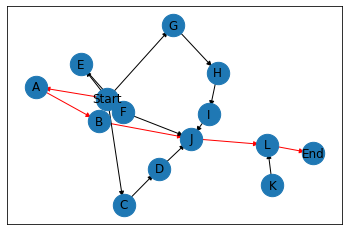

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()
g.add_nodes_from(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"])
g.add_edge("Start","A")
g.add_edge("Start","C")
g.add_edge("Start","E")
g.add_edge("Start","G")
g.add_edge("A","B")
g.add_edge("C","D")
g.add_edge("E","F")
g.add_edge("G","H")
g.add_edge("H","I")
g.add_edge("B","J")
g.add_edge("D","J")
g.add_edge("F","J")
g.add_edge("I","J")
g.add_edge("J","L")
g.add_edge("K","L")
g.add_edge("L","End")

# Specify the edges you want here
red_edges = [("Start", "A"), ('A', 'B'), ('B', 'J'), ('J', 'L'), ("L", "End")]
edge_colours = ['black' if not edge in red_edges else 'red'
                for edge in g.edges()]
black_edges = [edge for edge in g.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), node_size = 500)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(g, pos, edgelist=black_edges, arrows=True)
plt.show()

2. Find the earliest start time and earliest completion time for each activity.
3. Find the latest start time and latest completion time for each activity.
**Answer:** The earliest start time, earliest completion time, latest start time and latest completion time for each activity is given `ES`, `EF`, `LS` and `LF` in the table below.

In [13]:
data

,task,precedence,duration,ES,EF,LS,LF,slack,Is critical?
0,A,-1,30,0.0,30.0,0.0,30.0,0.0,Yes
1,B,A,5,30.0,35.0,30.0,35.0,0.0,Yes
2,C,-1,2,0.0,2.0,30.0,32.0,30.0,No
3,D,C,3,2.0,5.0,32.0,35.0,30.0,No
4,E,-1,7,0.0,7.0,3.0,10.0,3.0,No
5,F,E,25,7.0,32.0,10.0,35.0,3.0,No
6,G,-1,15,0.0,15.0,8.0,23.0,8.0,No
7,H,G,10,15.0,25.0,23.0,33.0,8.0,No
8,I,H,2,25.0,27.0,33.0,35.0,8.0,No
9,J,"[I, F, D, B]",10,35.0,45.0,35.0,45.0,0.0,Yes


4. Find the slack for each activity. Which of the paths is a critical path?

In [14]:
data[["task", "slack", "Is critical?"]]

,task,slack,Is critical?
0,A,0.0,Yes
1,B,0.0,Yes
2,C,30.0,No
3,D,30.0,No
4,E,3.0,No
5,F,3.0,No
6,G,8.0,No
7,H,8.0,No
8,I,8.0,No
9,J,0.0,Yes


In [15]:
print(critical_path)

['A', 'B', 'J', 'L']


5. Because of a phone call, you were interrupted for 6 minutes when you should have been cutting the onions and mushrooms. <br>By how much will the dinner be delayed?
**Answer:** The dinner will be delayed by 3 minutes since there is a slack time of 3 minutes for Task E.

6. If you use your food processor, which reduces the cutting time from 7 to 2 minutes, will the dinner still be delayed?
**Answer:** The dinner will not be delayed anymore since the task was finished 5 minutes earlier with additional 3 minutes slack time.